# Multinomial Regression Model for Classification

In [1]:
#import necessary libraries
import pandas as pd
import tensorflow as tf
MNIST = tf.keras.datasets.mnist
from matplotlib import pyplot as plt
import numpy as np

## Data loading

In [2]:
(x_train, y_train), (x_test, y_test) = MNIST.load_data()
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


#### MNIST image  visualisation with examples
We can see that MNIST dataset has handwritten digit images with 28X28 pixel size. Below shows 10 such examples with their class labels.

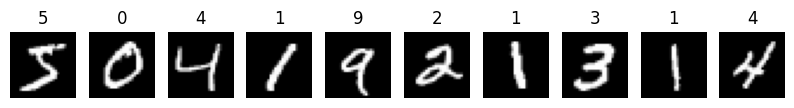

In [3]:
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

## Gradient Ascent Algorithm

#### Objective function given below can be written as:
$$
J(\beta _1,\beta _2, ... , \beta {k-1}) = l(\beta _1, ... ,\beta _{k-1})
$$

In [4]:
def objective_func(theta,lam, x, y):
    logits = np.dot(x, theta)
    log_likelihood = np.sum(logits[np.arange(len(x)), y.astype(np.int64)]) - np.sum(np.log(1+np.sum(np.exp(logits), axis=1))) 
    cost_function = log_likelihood - lam * 0.5 * np.sum(theta**2)
    return log_likelihood, cost_function

In [5]:
def softmax(logits):
    exp_logits = np.exp(logits)
    return exp_logits / (1 + np.sum(exp_logits, axis=1, keepdims=True))

def predict_proba(theta, x):
    logits = np.dot(x, theta)
    return softmax(logits)

def predict(theta, x):
    proba = predict_proba(theta, x)
    return np.argmax(proba, axis=1)

def compute_accuracy(theta, x, y):
    y_pred = predict(theta, x)
    return np.mean(y_pred == y)

def compute_gradient(theta, x, y, num_classes=10):
    m = len(x)
    logits = np.dot(x, theta) #dot product of x and theta
    proba = softmax(logits)
    # One-hot encode the labels to convert them into a vector of length 10 to match the output of the neural network.
    y_train_one_hot = tf.keras.utils.to_categorical(y)
    gradient = np.dot(x.T, y_train_one_hot - proba) / m
    return gradient

In [6]:
def gradient_ascent_logistic_regression(x_train, y_train, x_test, y_test, num_classes, eta=0.1, epsilon=0.01, max_iters=1001):
    # Initialize theta,the coefficient matrix, with small random values
    # Its shape is 784x10 as dot product of x_train (60K X784) and theta will give the logits of shape 60000x10.
    theta = np.zeros((x_train.shape[1], num_classes))
    costs = []
    loglikelihoods = []
    train_accs = []
    test_accs = []
    lam = 1
    for i in range(max_iters):
        gradient = compute_gradient(theta, x_train, y_train, num_classes)
        new_theta = theta + eta * gradient
        
        # Compute log-likelihood
        ll, cost = objective_func(new_theta, lam, x_train, y_train)
        costs.append(cost)
        loglikelihoods.append(ll)
        
        # Compute training accuracy
        train_acc = compute_accuracy(new_theta, x_train, y_train)
        train_accs.append(train_acc)
        
        # Compute testing accuracy
        test_acc = compute_accuracy(new_theta, x_test, y_test)
        test_accs.append(test_acc)
        
        # Print progress
        if i % 50 == 0:
            print(f"Iteration {i}: Training Accuracy = {train_acc}, Testing Accuracy = {test_acc}, Log-Likelihood = {cost}, gradiemt: {np.linalg.norm(gradient)}")
        
        # Check for convergence based on parameter change
        if np.linalg.norm(new_theta - theta) < epsilon:
            print(f"Convergence reached at iteration {i}")
            break
        
        # Check for convergence based on gradient norm
        if np.linalg.norm(eta * gradient) < epsilon:
            print(f"Gradient norm convergence reached at iteration {i}")
            break
        
        theta = new_theta
    
    return theta, costs, loglikelihoods, train_accs, test_accs

## Training

#### Preprocessing

In [7]:
x_train, x_test = x_train / 255.0, x_test / 255.0 #Normalize the images to bring them in the range of 0 to 1
# Each image is a 28x28 matrix. It is reshaped to a vector of length 784. -1 is taken to maintain the number of rows. 
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
# One-hot encode the labels to convert them into a vector of length 10 to match the output of the neural network.
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 784)
x_test shape: (10000, 784)


In [8]:
# Train the logistic regression classifier with modified stopping criteria
theta, costs, loglikelihoods, train_accs, test_accs = gradient_ascent_logistic_regression(x_train, y_train, x_test, y_test, num_classes=10, eta=0.1, epsilon=0.01)

Iteration 0: Training Accuracy = 0.6717833333333333, Testing Accuracy = 0.6804, Log-Likelihood = -137351.77067246885, gradiemt: 1.0546312166075251
Iteration 50: Training Accuracy = 0.8406666666666667, Testing Accuracy = 0.85, Log-Likelihood = -48120.82512085866, gradiemt: 0.2627083660448001
Iteration 100: Training Accuracy = 0.8605, Testing Accuracy = 0.87, Log-Likelihood = -36789.17495414509, gradiemt: 0.14771486747679483
Iteration 150: Training Accuracy = 0.8699666666666667, Testing Accuracy = 0.8786, Log-Likelihood = -32194.281041416758, gradiemt: 0.10525553146324515
Convergence reached at iteration 160


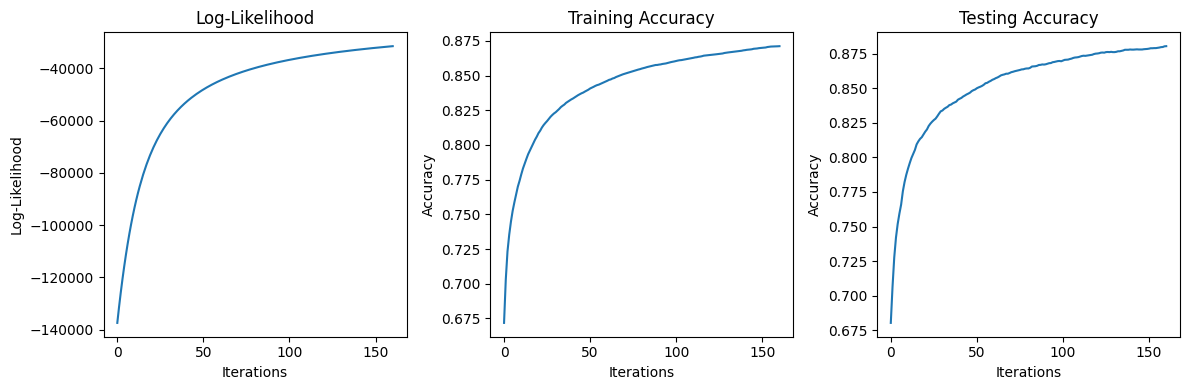

Final Testing Accuracy: 0.8804


In [9]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot 1: Cost value (log-likelihood)
plt.subplot(1, 3, 1)
plt.plot(loglikelihoods)
plt.title('Log-Likelihood')
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')

# Plot 2: Training accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

# Plot 3: Testing accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accs)
plt.title('Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Final testing accuracy
final_test_accuracy = test_accs[-1]
print(f"Final Testing Accuracy: {final_test_accuracy}")

Text(0.5, 1.0, 'Cost function vs iterations')

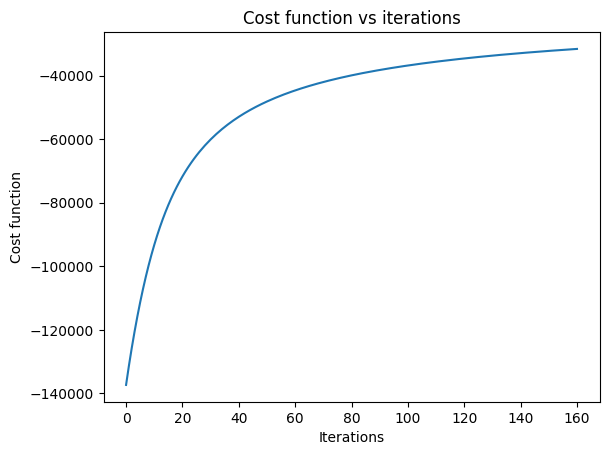

In [12]:
plt.figsize=(8, 2)
plt.plot(costs)
plt.title('Cost function')
plt.xlabel('Iterations')
plt.ylabel('Cost function')
plt.title('Cost function vs iterations')
